### This notebook plots MHW features over time (ocetrac output) as a multiple column subplot and a single MHW feature

#### Load libraries

In [1]:
#data stuff
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import dask

#date stuff
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import cftime

#Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

print('loaded libraries')

loaded libraries


In [2]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
dir_path = "/pub/mariant3/WarmWaterMasses/notebooks/02_mhw_metrics/data_ocetrac-labels/"

### Loading all data needed to make MHW evolution plot

In [3]:
ds = xr.open_dataset(f"{hfdrake_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc", chunks={'time':100})
static = xr.open_dataset(f"{hfdrake_path}/data/ocean_daily_cmip.static.nc")
ds_region = ds.sel(xh = slice(-138, 0), yh = slice(8, 49))
static_region = static.sel(xh = slice(-138, 0), yh = slice(8, 49))
ds_static_region = xr.merge([static_region,ds_region])

ocetrac_labels = xr.open_dataset(f"{dir_path}/01860503-01901020_ocetrac-labels-region.nc", chunks={'time':1})

In [4]:
labels = ocetrac_labels.blobs
labels.load();

In [5]:
#These are all the IDs (labels) in the region
ids = np.unique(labels.sel(xh = slice(-138, 0), yh = slice(8, 49)))
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([  3.,   6.,  22.,  25.,  26.,  32.,  34.,  35.,  36.,  37.,  40.,
        41.,  42.,  45.,  48.,  49.,  50.,  51.,  55.,  56.,  58.,  69.,
        71.,  74.,  75.,  78.,  79.,  80.,  84.,  86.,  87.,  88.,  89.,
        90.,  91.,  94.,  98.,  99., 101., 103., 112., 113., 116., 118.,
       119., 120., 122., 127., 128., 130., 132., 133., 143., 145., 146.,
       148., 153., 156., 158., 159., 171., 184., 186., 189., 190., 194.,
       201., 202., 208., 212., 220., 221., 223., 224., 226., 227., 228.,
       231., 237., 242., 244., 246., 247., 249., 252., 256.])

In [6]:
#ids186 are the unique events in one year
year = "0187"
ids186 = np.unique(labels.sel(time=slice(f'{year}',f'{year}')))
ids186 = np.array([id for id in ids186 if ~np.isnan(id)])
ids186

array([58., 69., 71., 74., 75., 78., 79., 80., 84., 86., 87., 88., 89.,
       90., 91.])

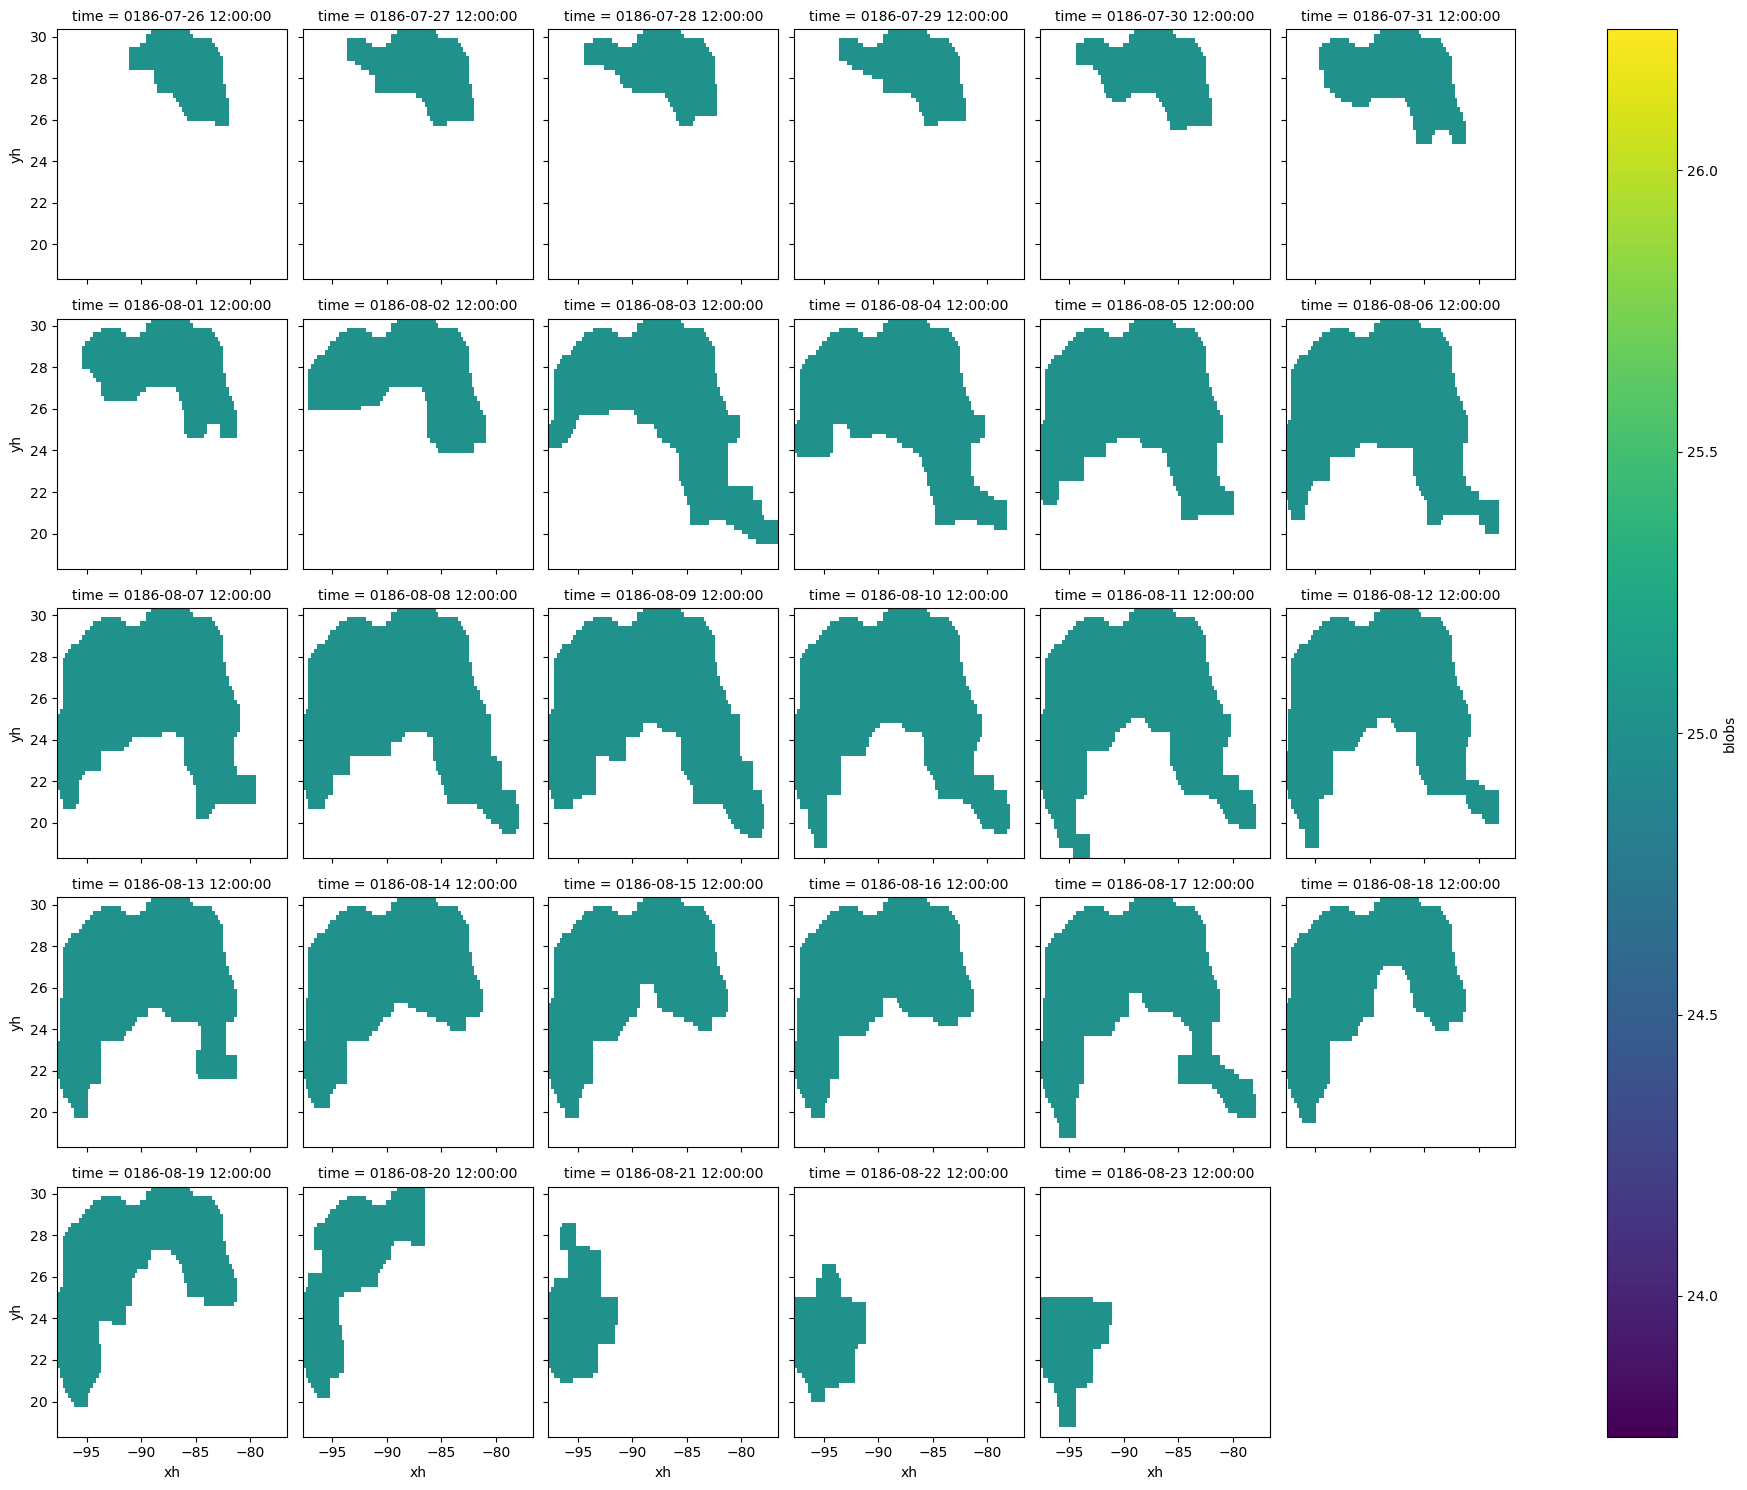

In [7]:
event_label = 25 #231 is a GoM event, event 26
blob = labels.where(labels==event_label, drop=True)


#blob.where(blob.plot(col="time", col_wrap=6))
#blob.plot(col="time", col_wrap=6)
#event.plot.contour()

#plt.show()

In [20]:
def plot_time_series(labels, start_time, end_time, num_cols=5, cmap=None, figsize=(20, 5),subplot_title_fontsize=12,colorbar_title='Colorbar',colorbar_title_fontsize=12,font_type='sans-serif',save_path=None):
    """
    Plots a time series of spatial data.

    Parameters:
    labels (xarray.DataArray): boolean array of ID's objects, in this case MHWs.
    start_time (int): The starting time index for the plots.
    end_time (int): The ending time index for the plots.
    num_cols (int, optional): Default is 5.
    cmap (str, optional): The colormap to use for the plots. Default is "tab20b".

    Returns:
    None
    """
    num_plots = end_time - start_time  # Number of plots
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    
    # Get the min and max values across all the time indices to normalize the color map
    ids_sel = np.unique(labels.isel(time=slice(start_time, end_time)))
    ids_sel = np.array([id for id in ids_sel if ~np.isnan(id)])
    vmin = np.min(ids_sel).astype(int)
    vmax = np.max(ids_sel).astype(int)
    back_color='#faf8eb'
    
         # Create a custom colormap with three colors if cmap is None
    if cmap is None:
        cmap = ListedColormap(np.random.random(size=(vmax, 3)).tolist())

    fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=figsize,facecolor=back_color)
    
    font_properties = FontProperties(family=font_type, size=subplot_title_fontsize)
    
    for i, time_index in enumerate(range(start_time, end_time)):
        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index
        ax = axes[row, col]
        
        c = labels.isel(time=time_index).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.coastlines()
        # ax.add_feature(cfeature.BORDERS, linestyle=':')
        # ax.gridlines(draw_labels=True)
        ax.set_xlim([-130, -70])
        ax.set_ylim([8, 38])
        date = labels.isel(time=time_index).time.dt.strftime('%Y-%m-%d').values
        ax.set_title(f'Time: {date}',fontproperties=font_properties)
        ax.set_facecolor(back_color)

    # Add colorbar with custom ticks
        
        #cbar = plt.colorbar(c, ax=ax)
        #cbar.set_ticks([])
       # cbar.set_label(colorbar_title, fontsize=colorbar_title_fontsize,fontproperties=FontProperties(family=font_type, size=colorbar_title_fontsize))
    # cbar = plt.colorbar(c, ax=axes.ravel().tolist(), ticks=[25])
    # cbar.set_label(colorbar_title, fontsize=colorbar_title_fontsize, fontproperties=FontProperties(family=font_type, size=colorbar_title_fontsize))
    
   
            
        cbar = plt.colorbar(c, ax=ax, ticks=np.arange(vmin, vmax + 1, 1))
        cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        cbar.ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
        cbar.set_label(colorbar_title, fontsize=colorbar_title_fontsize,fontproperties=FontProperties(family=font_type, size=colorbar_title_fontsize))
        cbar.ax.tick_params(labelsize=14)

    
    
    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[j])

    plt.tight_layout()
    
    if save_path:
        plt.savefig('/pub/mariant3/WarmWaterMasses/figures/MHW-labels-region-0187-30font-talk-background.png', bbox_inches='tight')

    #126
    
    plt.show()

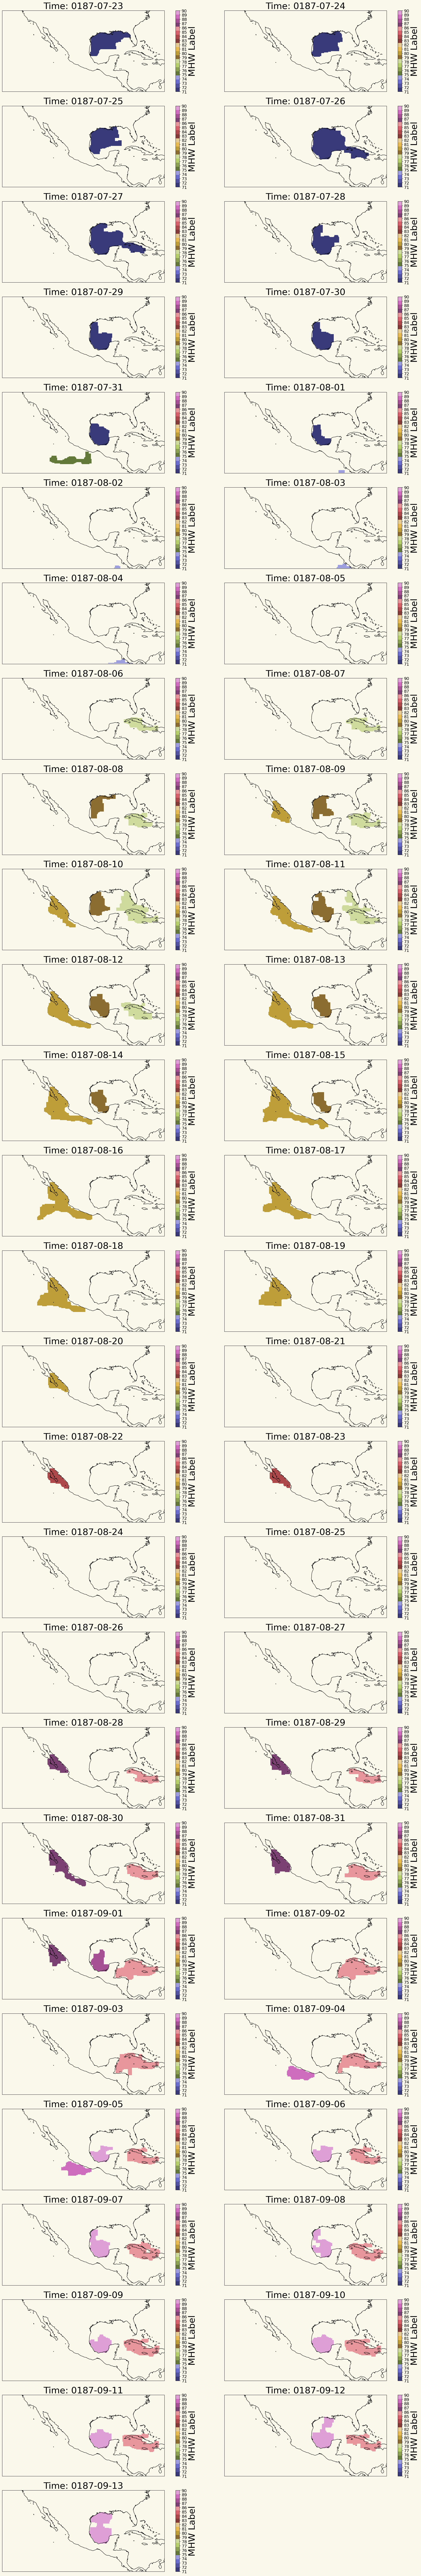

In [21]:
plot_time_series(labels, 252, 305,cmap="tab20b",num_cols=2,figsize=(21, 120),subplot_title_fontsize=30, colorbar_title='MHW Label', colorbar_title_fontsize=30,save_path=True)

In [7]:
id = 25
event = labels.where(labels==id, drop=True)
event.shape
event;

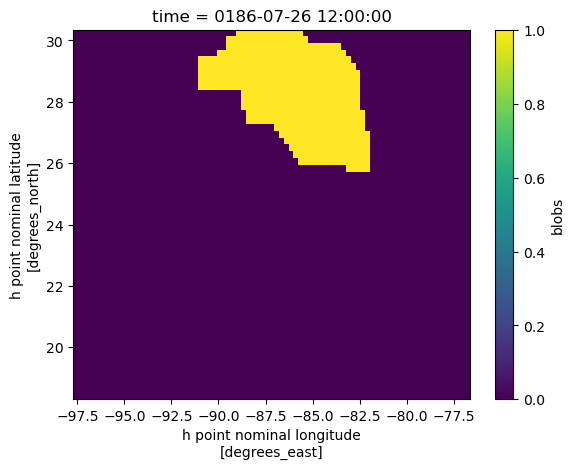

In [8]:
event_mask = event == event
event_mask.isel(time = 0).plot()

In [9]:
#quick fix for date issues
dates_evo = {
    'day1': (186, 6, 30),
    'day2': (186, 7, 15),
    'day3': (186, 7, 26), #206
    'i3': 206,
    'day4': (186, 8, 3),
    'day5': (186, 8, 10), #221
    'i5': 221,
    'day6': (186, 8, 21), #232
    'i6': 232,
    'day7': (186, 8, 28), #239
    'i7': 239,
    'day8': (186, 9, 5),
    'day9': (186, 9, 15),
    'day10': (186, 9, 30),
    'day11': (186, 10, 5),
    'day12': (186, 10, 15),
}

def cftime_string(date_tuple):
    year, month, day = date_tuple
    return f"{year:04d}-{month:02d}-{day:02d}"

In [50]:
i = 7
day = f'day{i}'
day_save = dates_evo[f'{day}']
date_save = cftime_string(day_save)
date_save

'0186-08-28'

In [51]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cftime
import numpy as np
import cmocean.cm as cmo

def plot_event_mask(event_mask, ds_static_region, labels, year, month, day, save_path=None, cbarlabelsize=12, fontsize=12):
    plt.figure(figsize=(20, 9),facecolor='#faf8eb')

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='#faf8eb')
    #ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    y=28

    date_sel = cftime.DatetimeNoLeap(year, month, day)
    
    event_mask_time = event_mask.sel(time=date_sel, method="nearest")

    #ds_static_region.sel(time=date_sel, method="nearest").sel(yh=slice(18, 32)).sel(xh=slice(-98, -75)).plot(vmin=22, vmax=29, cmap="Blues_r")

    #ds_static_region.tos.sel(time=date_sel, method="nearest").sel(yh=slice(18, 32)).sel(xh=slice(-98, -75)).plot(levels=np.arange(27, 28, 0.2),
                                                                                                   # colors="Blues_r", #colors=cmocean.cm.thermal, 
                                                                                                  #  add_colorbar=True)

    i = 7
    S = ds_static_region.tos.isel(time=dates_evo[f'i{i}']).plot(levels=np.arange(25, 29, 0.2), vmin=28, vmax=29 ,colors='Blues',add_colorbar=False) #levels=np.arange(25, 28, 0.5)

    Sc = ds_static_region.tos.isel(time=dates_evo[f'i{i}']).plot.contour(levels=np.arange(28, 28.5, 0.5),
                                       colors='#faf8eb',
                                       linewidths=1,
                                       linestyles='solid')
    
    plot = (ds_static_region.tos.sel(time=date_sel, method="nearest")
                         .where(event_mask.sel(time=date_sel, method="nearest"))
                         .plot(levels=np.arange(28, 31.6, 0.2),
                               colors=cmo.thermal, 
                               add_colorbar=False))

    C = (ds_static_region.tos.sel(time=date_sel, method="nearest")
                         .where(event_mask.sel(time=date_sel, method="nearest"))
                         .plot.contour(levels=np.arange(28, 33, 0.5),
                                       colors='#faf8eb',
                                       linewidths=1,
                                       linestyles='solid'))

    plt.clabel(C, inline=True, fontsize=17)
    plt.clabel(Sc, inline=True, fontsize=17, colors='#faf8eb')

   

    # Add contour lines for event_mask data
    C_event_mask = event_mask_time.plot.contour(levels=[0.6], colors='#89CC04', linewidths=5.5, linestyles='-') ##c53f4e

    date_temp = labels.sel(time=date_sel, method="nearest").time.dt.strftime('%Y-%m-%d').values

    ax.set_title(f'Date: {date_temp}', fontsize=fontsize)
    ax.set_xlim([-98, -75])
    ax.set_ylim([18, 32])
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}
    plt.axhline(y=y, color='#89CC04', linestyle='--',linewidth=3)
    #plt.axhline(y=22, color='k', linestyle='--')

    colorbar2 = plt.colorbar(S, ax=ax)
    colorbar2.set_label(r'SST [$^{\circ}$C]', fontsize=fontsize)
    colorbar2.ax.tick_params(labelsize=cbarlabelsize)

    # Add a colorbar for the mappable object
    colorbar = plt.colorbar(plot, ax=ax)
    colorbar.set_label(r'MHW SST [$^{\circ}$C]', fontsize=fontsize)
    colorbar.ax.tick_params(labelsize=cbarlabelsize)

   # plt.tight_layout()


    # Change colorbar font size
    # cbar = plot.colorbar
    # cbar.ax.tick_params(labelsize=cbarlabelsize) 
    # cbar.set_label(r'SST [$^{\circ}$C]', fontsize=fontsize)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
        

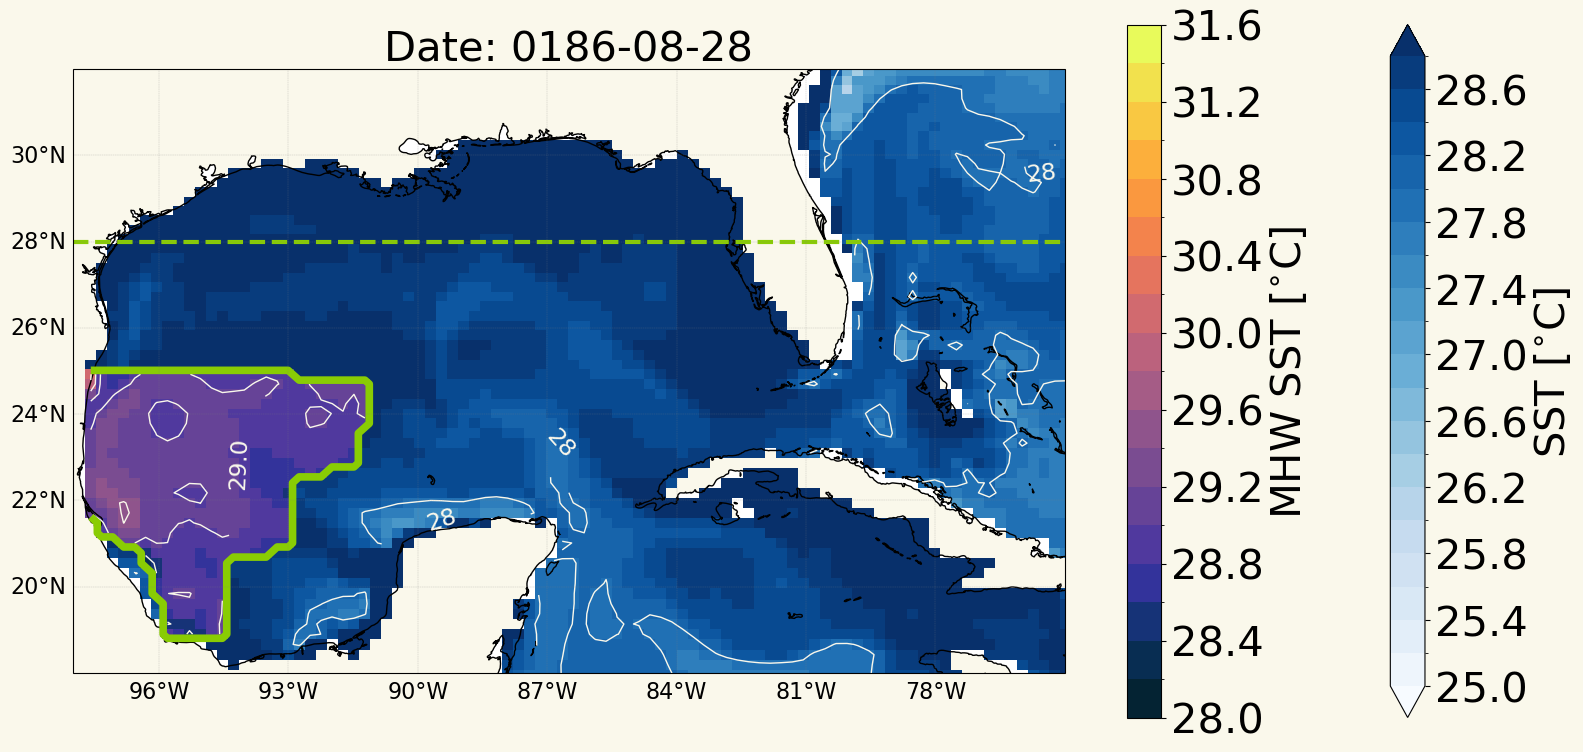

In [52]:
y=28

plot_event_mask(event_mask,
                ds_static_region,
                labels,
                dates_evo[f'{day}'][0],
                dates_evo[f'{day}'][1],
dates_evo[f'{day}'][2],
cbarlabelsize=30,
fontsize=30,save_path=f'/pub/mariant3/WarmWaterMasses/figures/mhw-2d-{date_save}-{y}N-colorbar-sst.png')
